# Introduction
The research questions is as follows: <br>
<br>
How different variables such as **actual delivery time**, **the difference between actual and estimated wait time**, **freight value**, **payment value**, **payment installment** affect the **review score** in each of the different **product type categories**, `Houseware`, `auto`, `furniture decor`, `computer accessories`, `health beauty`, `sports leisure`? <br>

In this python notebook, the `max_depth` and `n_estimators` obtained from the GV search is run into random forest to obtain the classification accuracy, true positive, true negative, false positive, false negative values. 

All the extracting and cleaning codes are similar to earlier parts. 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

In [2]:
olist_orders_dataset = pd.read_csv("olist_orders_dataset.csv")
olist_order_reviews_dataset = pd.read_csv("olist_order_reviews_dataset.csv")
olist_order_payments_dataset = pd.read_csv("olist_order_payments_dataset.csv")
olist_order_items_dataset = pd.read_csv("olist_order_items_dataset.csv")
olist_products_dataset = pd.read_csv("olist_products_dataset.csv")
product_category_name_translation = pd.read_csv("product_category_name_translation.csv")

### Merging the Datasets

In [3]:
olist_merge = olist_orders_dataset.merge(olist_order_reviews_dataset, on="order_id", how = 'left')
olist_merge = olist_merge.merge(olist_order_payments_dataset, on="order_id", how = 'left')
olist_merge = olist_merge.merge(olist_order_items_dataset, on="order_id", how = 'left')
olist_merge = olist_merge.merge(olist_products_dataset, on="product_id", how = 'left')

### Removing Duplicates and extracting needed variables 

In [4]:
olist_merge.drop_duplicates(subset=["review_score", "order_id"], inplace = True)

In [5]:
dataAnalysis = pd.DataFrame(olist_merge[['order_status','order_purchase_timestamp', 'order_approved_at', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'review_score', 'payment_installments', 'payment_value', 'freight_value', 'product_category_name']])

In [6]:
# Creating a list of the time related variables 
time = ["order_purchase_timestamp","order_estimated_delivery_date","order_delivered_customer_date", "order_approved_at"]
# Changing the time related variables to datetime format using the list 
for column in time:
    dataAnalysis.loc[:, column] = pd.to_datetime(dataAnalysis[column])

In [7]:
# Calculating the actual wait time    
dataAnalysis.loc[:,"actual_wait_time"] = (dataAnalysis['order_delivered_customer_date']-dataAnalysis['order_purchase_timestamp']).dt.days

In [8]:
# Calculating the estimated wait time 
dataAnalysis.loc[:,"estimated_wait_time"] = (dataAnalysis['order_estimated_delivery_date']-dataAnalysis['order_purchase_timestamp']).dt.days

In [9]:
#Actual minus estimated wait time 
dataAnalysis.loc[:,"actualxestimated"] = (dataAnalysis['actual_wait_time']-dataAnalysis['estimated_wait_time'])

In [10]:
dataAnalysis.drop(columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'estimated_wait_time'], inplace = True)

In [11]:
dataAnalysis = dataAnalysis.loc[(dataAnalysis["order_status"]=="delivered")]

In [12]:
# Calculating the actual wait time    
dataAnalysis.loc[:,"reviewscore"] = dataAnalysis["review_score"]//3

In [13]:
# Original review score no longer needed
dataAnalysis.drop(columns = ['review_score'], inplace = True)

In [14]:
#merging with english name first 
dataAnalysis = pd.merge(dataAnalysis,product_category_name_translation,how="left",on="product_category_name")

In [15]:
housewareProd = dataAnalysis.loc[(dataAnalysis["product_category_name_english"]=="housewares")]

# Defining a balance function to balance the two classes
def balancing(dataframe):
    # Class count
    count_class_1, count_class_0 = dataframe.reviewscore.value_counts() #split the dataframe based on review scores into 1 and 0

    # Divide by class 1 and 0 to create two different dataframes
    df_class_0 = dataframe[dataframe['reviewscore'] == 0] 
    df_class_1 = dataframe[dataframe['reviewscore'] == 1]

    #Sample the class 0 (review score 0) by the number of review 1s
    df_class_0_over = df_class_0.sample(count_class_1, replace=True)
    dataframe = pd.concat([df_class_1, df_class_0_over], axis=0)
    return dataframe #return the dataframe

housewareProd = balancing(housewareProd)
# since there is no null values, no further cleaning is required. 

In [16]:
autoProd = dataAnalysis.loc[(dataAnalysis["product_category_name_english"]=="auto")]

In [17]:
#Needs cleaning and removal of null values 
autoProd = autoProd.loc[(autoProd["actual_wait_time"].notnull())]
autoProd=balancing(autoProd)

In [18]:
#No need further cleaning
furnitureProd = dataAnalysis.loc[(dataAnalysis["product_category_name_english"]=="furniture_decor")]
furnitureProd = balancing(furnitureProd)

In [19]:
CompAcProd = dataAnalysis.loc[(dataAnalysis["product_category_name_english"]=="computers_accessories")]

In [20]:
#Needs cleaning and removal of null values 
CompAcProd = CompAcProd.loc[(CompAcProd["actual_wait_time"].notnull())]
CompAcProd=balancing(CompAcProd)

In [21]:
healthProd = dataAnalysis.loc[(dataAnalysis["product_category_name_english"]=="health_beauty")]

In [22]:
#Needs further cleaning 
healthProd = healthProd.loc[(healthProd["payment_installments"].notnull())]
healthProd=balancing(healthProd)

In [23]:
sportsProd = dataAnalysis.loc[(dataAnalysis["product_category_name_english"]=="sports_leisure")]

In [24]:
#Needs further cleaning 
sportsProd = sportsProd.loc[(sportsProd["actual_wait_time"].notnull())]
sportsProd=balancing(sportsProd)

#### Creating function for random forest on the product types with parameters estim and mdepth

In [25]:
def train_and_predict(dataframe, estim, mdepth):
    # Import essential models and functions from sklearn
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import confusion_matrix

    # Extract Response and Predictors
    y = pd.DataFrame(dataframe['reviewscore'])
    X = pd.DataFrame(dataframe[["payment_installments", "payment_value", "freight_value", "actual_wait_time", "actualxestimated"]]) 

    # Split the Dataset into Train and Test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

    # Import RandomForestClassifier model from Scikit-Learn
    from sklearn.ensemble import RandomForestClassifier

    # Create the Random Forest object
    rforest = RandomForestClassifier(n_estimators = estim,  # n_estimators denote number of trees
                                     max_depth = mdepth)       # set the maximum depth of each tree

    # Fit Random Forest on Train Data
    rforest.fit(X_train, y_train.reviewscore.ravel())

    # Predict the Response corresponding to Predictors
    y_train_pred = rforest.predict(X_train)
    y_test_pred = rforest.predict(X_test)
    
    # Check the Goodness of Fit (on Train Data)
    print("Goodness of Fit of Model: Train Dataset")
    print("Classification Accuracy : ", rforest.score(X_train, y_train))
    confusion_matrix_train = confusion_matrix(y_train, y_train_pred)
    TN = confusion_matrix_train[0,0]
    TP = confusion_matrix_train[1,1]
    FP = confusion_matrix_train[0,1]
    FN = confusion_matrix_train[1,0]
    print("True Negative Rate      : ", TN/(TN+FP))
    print("True Positive Rate      : ", TP/(TP+FN))
    print("False Negative Rate     : ", FN/(FN+TP))
    print("False Positive Rate     : ", FP/(TN+FP))
    print()

    # Check the Goodness of Fit (on Test Data)
    print("Goodness of Fit of Model: Test Dataset")
    print("Classification Accuracy : ", rforest.score(X_test, y_test))
    confusion_matrix_test = confusion_matrix(y_test, y_test_pred)
    TN = confusion_matrix_test[0,0]
    TP = confusion_matrix_test[1,1]
    FP = confusion_matrix_test[0,1]
    FN = confusion_matrix_test[1,0]
    print("True Negative Rate      : ", TN/(TN+FP))
    print("True Positive Rate      : ", TP/(TP+FN))
    print("False Negative Rate     : ",FN/(FN+TP))
    print("False Positive Rate     : ", FP/(TN+FP))

    # Plot the Confusion Matrix for Train and Test
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    sb.heatmap(confusion_matrix(y_train, y_train_pred),
               annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
    sb.heatmap(confusion_matrix(y_test, y_test_pred), 
               annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

Goodness of Fit of Model: Train Dataset
Classification Accuracy :  0.9964841788046208
True Negative Rate      :  1.0
True Positive Rate      :  0.992936427850656
False Negative Rate     :  0.007063572149344097
False Positive Rate     :  0.0

Goodness of Fit of Model: Test Dataset
Classification Accuracy :  0.9545043687857788
True Negative Rate      :  0.9945021380574222
True Positive Rate      :  0.915576694411415
False Negative Rate     :  0.08442330558858502
False Positive Rate     :  0.005497861942577886


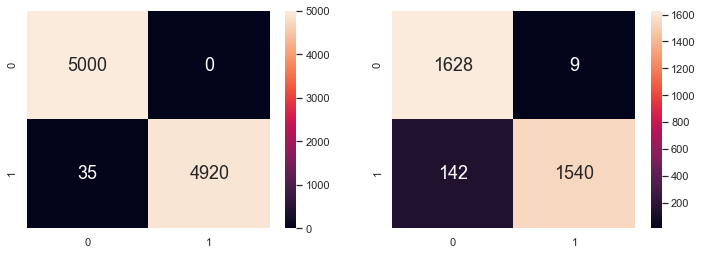

In [26]:
train_and_predict(sportsProd, 10, 800)

Goodness of Fit of Model: Train Dataset
Classification Accuracy :  0.9953445065176909
True Negative Rate      :  1.0
True Positive Rate      :  0.9907358390682901
False Negative Rate     :  0.009264160931709899
False Positive Rate     :  0.0

Goodness of Fit of Model: Test Dataset
Classification Accuracy :  0.9573024740622506
True Negative Rate      :  0.9960691823899371
True Positive Rate      :  0.9173419773095624
False Negative Rate     :  0.08265802269043761
False Positive Rate     :  0.003930817610062893


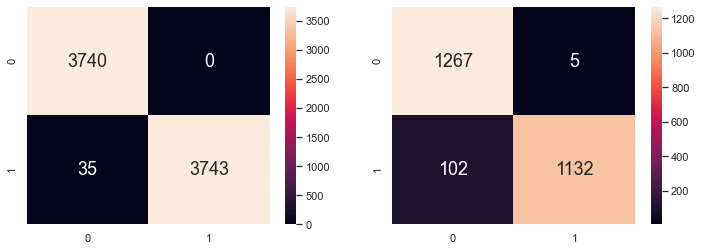

In [27]:
train_and_predict(housewareProd, 10, 400)

Goodness of Fit of Model: Train Dataset
Classification Accuracy :  0.9960643694245234
True Negative Rate      :  0.9998244382022472
True Positive Rate      :  0.9923318229348205
False Negative Rate     :  0.007668177065179505
False Positive Rate     :  0.00017556179775280898

Goodness of Fit of Model: Test Dataset
Classification Accuracy :  0.9588142707240294
True Negative Rate      :  0.9922158796056045
True Positive Rate      :  0.9246684350132626
False Negative Rate     :  0.0753315649867374
False Positive Rate     :  0.007784120394395433


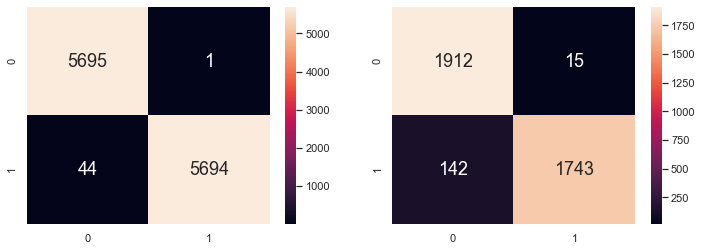

In [28]:
train_and_predict(healthProd, 10, 800)

Goodness of Fit of Model: Train Dataset
Classification Accuracy :  0.9971688574317492
True Negative Rate      :  1.0
True Positive Rate      :  0.994341147938561
False Negative Rate     :  0.005658852061438965
False Positive Rate     :  0.0

Goodness of Fit of Model: Test Dataset
Classification Accuracy :  0.9539114614918133
True Negative Rate      :  0.9987893462469734
True Positive Rate      :  0.9088699878493317
False Negative Rate     :  0.0911300121506683
False Positive Rate     :  0.0012106537530266344


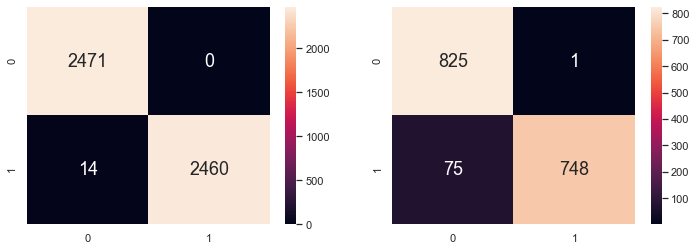

In [29]:
train_and_predict(autoProd, 10, 500)

Goodness of Fit of Model: Train Dataset
Classification Accuracy :  0.9940033581194531
True Negative Rate      :  0.999043062200957
True Positive Rate      :  0.9889369889369889
False Negative Rate     :  0.011063011063011063
False Positive Rate     :  0.0009569377990430622

Goodness of Fit of Model: Test Dataset
Classification Accuracy :  0.9280575539568345
True Negative Rate      :  0.9869470630891951
True Positive Rate      :  0.8700927908636689
False Negative Rate     :  0.1299072091363312
False Positive Rate     :  0.01305293691080493


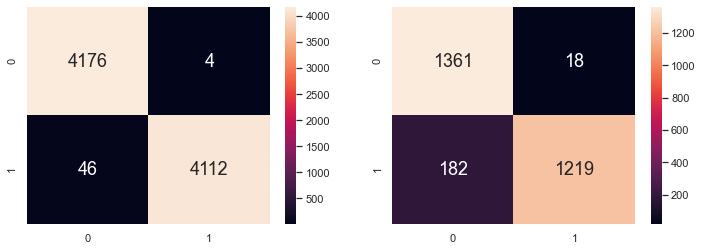

In [30]:
train_and_predict(CompAcProd, 10, 500)

Goodness of Fit of Model: Train Dataset
Classification Accuracy :  0.9946916076845298
True Negative Rate      :  0.9987471811576046
True Positive Rate      :  0.9905636317266003
False Negative Rate     :  0.009436368273399644
False Positive Rate     :  0.0012528188423953897

Goodness of Fit of Model: Test Dataset
Classification Accuracy :  0.9226686884003032
True Negative Rate      :  0.9922118380062306
True Positive Rate      :  0.8567208271787297
False Negative Rate     :  0.1432791728212703
False Positive Rate     :  0.00778816199376947


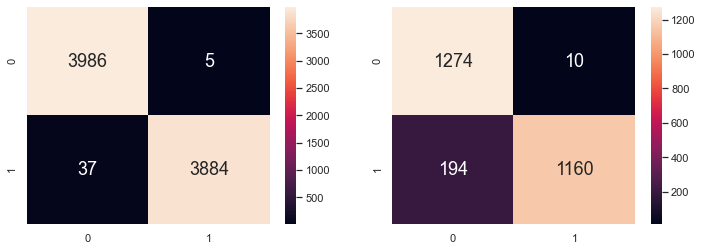

In [31]:
train_and_predict(furnitureProd, 10, 200)

Goodness of Fit of Model: Train Dataset
Classification Accuracy :  0.9983927674535409
True Negative Rate      :  0.9995987158908507
True Positive Rate      :  0.9971836652584993
False Negative Rate     :  0.002816334741500704
False Positive Rate     :  0.0004012841091492777

Goodness of Fit of Model: Test Dataset
Classification Accuracy :  0.9780054233202772
True Negative Rate      :  0.9981851179673321
True Positive Rate      :  0.957983193277311
False Negative Rate     :  0.04201680672268908
False Positive Rate     :  0.0018148820326678765


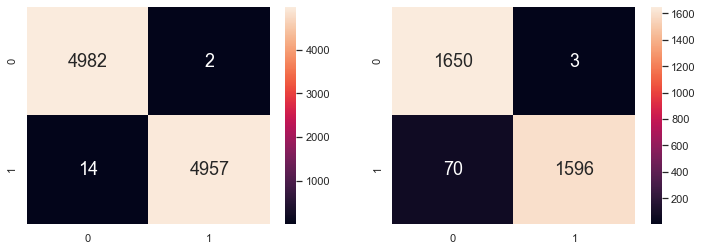

In [32]:
train_and_predict(sportsProd, 13, 900)

Goodness of Fit of Model: Train Dataset
Classification Accuracy :  0.9976057462090981
True Negative Rate      :  1.0
True Positive Rate      :  0.9952089433058291
False Negative Rate     :  0.004791056694170881
False Positive Rate     :  0.0

Goodness of Fit of Model: Test Dataset
Classification Accuracy :  0.9604948124501197
True Negative Rate      :  0.9920063948840927
True Positive Rate      :  0.9290836653386454
False Negative Rate     :  0.07091633466135458
False Positive Rate     :  0.007993605115907274


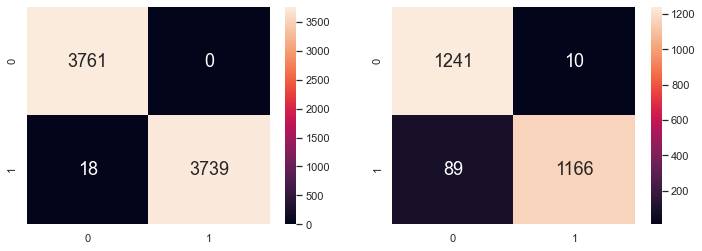

In [33]:
train_and_predict(housewareProd, 13, 600)

Goodness of Fit of Model: Train Dataset
Classification Accuracy :  0.9976386216547141
True Negative Rate      :  0.9996519317786287
True Positive Rate      :  0.995604781997187
False Negative Rate     :  0.004395218002812939
False Positive Rate     :  0.0003480682213713888

Goodness of Fit of Model: Test Dataset
Classification Accuracy :  0.968520461699895
True Negative Rate      :  0.9930740543420352
True Positive Rate      :  0.944702842377261
False Negative Rate     :  0.05529715762273902
False Positive Rate     :  0.006925945657964837


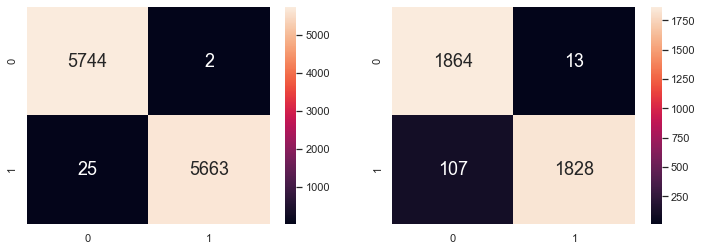

In [34]:
train_and_predict(healthProd, 13, 800)

Goodness of Fit of Model: Train Dataset
Classification Accuracy :  0.9981799797775531
True Negative Rate      :  0.9988019169329073
True Positive Rate      :  0.9975419909873003
False Negative Rate     :  0.0024580090126997134
False Positive Rate     :  0.0011980830670926517

Goodness of Fit of Model: Test Dataset
Classification Accuracy :  0.9581564584596726
True Negative Rate      :  0.9899117276166457
True Positive Rate      :  0.9287383177570093
False Negative Rate     :  0.07126168224299065
False Positive Rate     :  0.01008827238335435


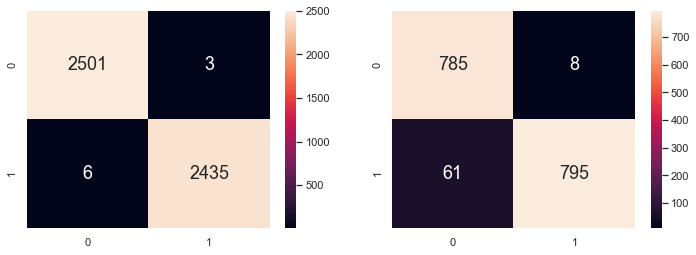

In [35]:
train_and_predict(autoProd, 13, 300)

Goodness of Fit of Model: Train Dataset
Classification Accuracy :  0.9964020148716719
True Negative Rate      :  0.9988083889418494
True Positive Rate      :  0.9939642684693385
False Negative Rate     :  0.006035731530661516
False Positive Rate     :  0.0011916110581506197

Goodness of Fit of Model: Test Dataset
Classification Accuracy :  0.9446043165467626
True Negative Rate      :  0.9889948642699926
True Positive Rate      :  0.9019054340155258
False Negative Rate     :  0.09809456598447425
False Positive Rate     :  0.011005135730007337


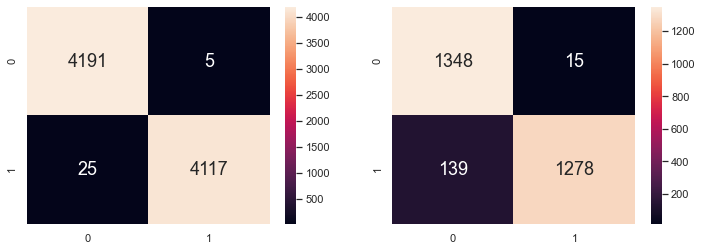

In [36]:
train_and_predict(CompAcProd, 13, 700)

Goodness of Fit of Model: Train Dataset
Classification Accuracy :  0.9959555106167847
True Negative Rate      :  0.9997476659096644
True Positive Rate      :  0.9921499113699671
False Negative Rate     :  0.00785008863003292
False Positive Rate     :  0.00025233409033560434

Goodness of Fit of Model: Test Dataset
Classification Accuracy :  0.9499620924943138
True Negative Rate      :  0.9870426829268293
True Positive Rate      :  0.9132730015082956
False Negative Rate     :  0.08672699849170437
False Positive Rate     :  0.012957317073170731


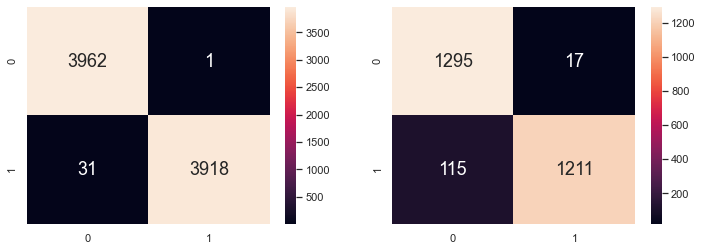

In [37]:
train_and_predict(furnitureProd, 13, 900)

# Check Point: Analysis 


After feeding in the best hyperparameters obtained through the GV Search, it can be seen that the train and test classification accuracy is very similar. This suggests that no overfitting occurred. Overfitting occurs when the train dataset has good classification accuracy, true positive and true negative but terrible classification accuracy, true positive and true negative when test data is used. In the above scenario, the classification accuracy, true positive and true negative is similar for both test and train. Hence, no overfitting has occurred. 

However, classification accuracy, true positive and true negative is still very high and this could be due to the upsampling of review score 0 done earlier. Upscaling can lead to overfitting. 

# In Conclusion and summary to the entire project, 
A decision tree (part 6) is a basic machine learning tool that did not provide a very high classification accuracy(65% to 75%), true positive(60% to 85%) and true negative(50% to 60%). There was a large distribution of these values across product types too. Every time the notebook is run, the train and test classification accuracy would differ from a range of 1% to 10%. Additionally, false positive was above 40% for most product types across multiple runs of the ipynb. This shows that the machine learning tool was not the best. 

Another option was to run random forest. A random forest uses a 'forest', a multitude of decisions trees that help to classify the data points into the different review scores. The reason why random forest works so well is that "A large number of relatively uncorrelated models (trees) operating as a committee will outperform any of the individual constituent models." [1]

There is low correlation between the trees and the trees help to cover each others errors to enable the most accurate classification. Hence we see that the random forest does enable better classification in part 7. Classification accuracy increase above 80% and false positive rates fell below 30%. Train and test were similar in terms of classification accuracy. 

False positives are generally bad given our reseach question. This is because sellers want to adjust their **actual delivery time**, **the difference between actual and estimated wait time**, **freight value**, **payment value**, **payment installment** such that they obtain the best review score 1 which is translated to 3 to 5 review score. If they adjust these factors and get a false positive, then they may predict a high review score but end up getting a low one. 

Hence, although the classification accuracy is relatively better, an additional step must be done to reduce the false positive. Tuning of hyperparameters must be done to achieve the highest possible classification accuracy, true positive and true negative and lowest possible false positive and false negative. Hyperparameters are used to make the random forest. There are many hyperparameters but for the scope of this project max_depth and n_estimators were chosen. max_depth is the maximum depth each decision tree goes in the 'forest' of trees. n_estimators is the number of trees in the forest. [2]

To find the best hyperparemeters a Grid Search is done.[3][4][5][6][7][8]

Grid Search will then run a range for the hyperparameters as seen in part 7. The definition provided by Sci-Kit is "The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid." 
Cross validation is defined as "Cross validation is a statistical method used to estimate the performance (or accuracy) of machine learning models." [9]

Best score is the "Mean cross-validated score of the best_estimator". Since cv = 5, the train and test split will occur five times for each hyperparameter. The best score is calculated for each try and for each combination of hyperparameters. The best score will return the average of the best hyperparameter combination in those 5 tries. 

This function will return the best hyperparameters max_depth and n_estimators. These are then run into the random forest in this very ipynb. Seen from above, classification accuracy, true positive and true negative are above 95% and false positive and false negative are below 1% for all product types. Train and test data are very similar. Hence, there is no overfitting as explained earlier. 


Reference List (for this notebook):

1. “sklearn.ensemble.randomforestclassifier¶.” [Online]. Available: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html. [Accessed: 21-Apr-2021]. 


2. R. Meinert, “Optimizing Hyperparameters in Random Forest Classification,” Medium, 07-Jun-2019. [Online]. Available: https://towardsdatascience.com/optimizing-hyperparameters-in-random-forest-classification-ec7741f9d3f6. [Accessed: 21-Apr-2021]. 


3. M. Sharma, “Grid Search for Hyperparameter Tuning,” Medium, 21-Mar-2020. [Online]. Available: https://towardsdatascience.com/grid-search-for-hyperparameter-tuning-9f63945e8fec. [Accessed: 21-Apr-2021]. 


4. “sklearn.model_selection.GridSearchCV¶,” scikit. [Online]. Available: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html. [Accessed: 21-Apr-2021]. 


5. J. Brownlee, “Hyperparameter Optimization With Random Search and Grid Search,” Machine Learning Mastery, 18-Sep-2020. [Online]. Available: https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/. [Accessed: 21-Apr-2021]. 


6. Shahul ES Freelance Data Scientist | Kaggle Master Data science professional with a strong end to end data science/machine learning and deep learning (NLP) skills. Experienced working in a Data Science/ML Engineer role in multiple startups. K, S. ES, Freelance Data Scientist | Kaggle Master Data science professional with a strong end to end data science/machine learning and deep learning (NLP) skills. Experienced working in a Data Science/ML Engineer role in multiple startups. Kaggle Kernels Master ra, and F. me on, “Hyperparameter Tuning in Python: a Complete Guide 2021,” neptune.ai, 19-Mar-2021. [Online]. Available: https://neptune.ai/blog/hyperparameter-tuning-in-python-a-complete-guide-2020#:~:text=Hyperparameter%20tuning%20is%20the%20process,maximum%20performance%20out%20of%20models. [Accessed: 21-Apr-2021]. 


7. R. Joseph, “Grid Search for model tuning,” Medium, 29-Dec-2018. [Online]. Available: https://towardsdatascience.com/grid-search-for-model-tuning-3319b259367e. [Accessed: 21-Apr-2021]. 


8. abuabu 54777 silver badges1616 bronze badges, Mischa LisovyiMischa Lisovyi                    2, and Vivek KumarVivek Kumar 28.8k66 gold badges7575 silver badges109109 bronze badges, “Interpreting sklearns' GridSearchCV best score,” Stack Overflow, 01-Feb-1967. [Online]. Available: https://stackoverflow.com/questions/50232599/interpreting-sklearns-gridsearchcv-best-score. [Accessed: 21-Apr-2021]. 


9. H. M. -, By, -, Hussain MujtabaHussain is a computer science engineer who specializes in the field of Machine Learning.He is a freelance programmer and fancies trekking, H. Mujtaba, Hussain is a computer science engineer who specializes in the field of Machine Learning.He is a freelance programmer and fancies trekking, and P. enter your name here, “What is Cross Validation in Machine learning? Types of Cross Validation,” GreatLearning Blog: Free Resources what Matters to shape your Career!, 24-Sep-2020. [Online]. Available: https://www.mygreatlearning.com/blog/cross-validation/. [Accessed: 21-Apr-2021]. 